In [14]:
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [15]:
# List output from PGCFinder pipeline:
list_output = "../../results/lists_all/list_organisms_merged.csv"
# Directory with the PGCFinder pipeline output:
data_path = "../../data/genomes_PGC_v2.2/"

In [16]:
# Pandas reading
df_list_all = pd.read_csv(list_output)
df_list_PGC = df_list_all[df_list_all["number of genes"] > 24]
print(df_list_PGC)

                           Assembly               #Organism Name  \
60     GCA_023380025.1_ASM2338002v1         Sphingomonas glaciei   
165      GCA_000225955.1_ASM22595v1    Rhodospirillum rubrum F11   
332     GCA_001412575.1_ASM141257v1    Limnohabitans sp. 103DPR2   
557     GCA_003065365.1_ASM306536v1  Polynucleobacter difficilis   
827    GCA_025917005.1_ASM2591700v1    Porphyrobacter sp. ULC335   
...                             ...                          ...   
35005   GCA_001713455.1_ASM171345v1              Bosea sp. RAC05   
35410  GCA_011388215.1_ASM1138821v1        Hydrogenophaga crocea   
35692   GCA_001713375.1_ASM171337v1     Hydrogenophaga sp. RAC07   
35716  GCA_016584445.1_ASM1658444v1   Rhodopseudomonas palustris   
36215  GCA_019623905.1_ASM1962390v1      Neotabrizicola shimadae   

                                   Organism Groups   Strain     BioSample  \
60     Bacteria;Pseudomonadota;Alphaproteobacteria    S8-45  SAMN27863982   
165    Bacteria;Pseudomonadot

In [17]:
def create_gene_scores(df_list, lists_genes, data_path):
    dfs = {}
    df_results = df_list.copy()
    df_results["to_compare"] = df_results["Assembly"].str.replace('GCA_', '')

    for index, row in df_results.iterrows():
        genome_gcf = f"GCF_{row['to_compare']}"
        genome_gca = f"GCA_{row['to_compare']}"
        path_gcf = os.path.join(data_path, genome_gcf, "PGCfinder", "best_solution.tsv")
        path_gca = os.path.join(data_path, genome_gca, "PGCfinder", "best_solution.tsv")

        if os.path.exists(path_gcf):
            genome = genome_gcf
            path_to_gff = path_gcf
        elif os.path.exists(path_gca):
            genome = genome_gca
            path_to_gff = path_gca
        else:
            print(f"No PGCfinder output found for {row['Assembly']}")
            continue

        dfs[genome] = pd.read_csv(path_to_gff, sep="\t", comment="#")

    # Dictionnaire pour stocker les scores de chaque gène
    gene_scores = {gene: [] for gene in lists_genes}

    # Boucle à travers chaque génome
    for genome in dfs:
        df = dfs[genome]
        for gene in lists_genes:
            if gene in df['gene_name'].values:
                scores = df[df['gene_name'] == gene]['hit_score'].tolist()
                gene_scores[gene].extend(scores)

    return gene_scores


In [18]:
# Gathering the PGC infos from all the genomes with one
def PGCfinder_output_gatherer(df_list, lists_genes):
    dfs = {}
    df_results = df_list.copy()
    df_results["to_compare"] = df_results["Assembly"].str.replace('GCA_', '') # parsing the assembly to gather the informations for looking to the right folders

    for index, row in df_results.iterrows():
        # Way to search for the GCF folder or the GCA if it doesn't exist
        genome_gcf = f"GCF_{row['to_compare']}"
        genome_gca = f"GCA_{row['to_compare']}"
        path_gcf = os.path.join(data_path, genome_gcf, "PGCfinder", "best_solution.tsv")
        path_gca = os.path.join(data_path, genome_gca, "PGCfinder", "best_solution.tsv")

        # Reading of the GFF
        if os.path.exists(path_gcf):
            genome = genome_gcf
            path_to_gff = path_gcf
        elif os.path.exists(path_gca):
            genome = genome_gca
            path_to_gff = path_gca
        else:
            print(f"No PGCfinder output found for {row['Assembly']}")
            continue  # Skip this genome if no file is found

        dfs[genome] = pd.read_csv(path_to_gff, sep="\t", comment="#")
        # Dictionnaire pour stocker les occurrences de chaque gène

    gene_counts = {gene: 0 for gene in lists_genes}

    # Boucle à travers chaque génome
    for genome in dfs:
        # Charger le DataFrame pour le génome actuel
        df = dfs[genome]
        
        # Boucle à travers chaque profil de gène
        for gene in lists_genes:
            # Vérifier si le gène est présent dans le DataFrame
            if gene in df['gene_name'].values:
                # Incrémenter le compte pour le gène actuel
                gene_counts[gene] += 1

    # Calculer le nombre total de génomes
    total_genomes = len(dfs[genome])

    # Calculer la fréquence de chaque gène
    gene_frequencies = {gene: (count / total_genomes) * 100 for gene, count in gene_counts.items()}

    # Trier les gènes par ordre alphabétique
    sorted_genes = sorted(gene_frequencies.keys())

    # Récupérer les fréquences triées selon les noms de gènes
    sorted_frequencies = [gene_frequencies[gene] for gene in sorted_genes]

    # Calculer les occurrences pour chaque gène trié
    occurrences = [gene_counts[gene] for gene in sorted_genes]

    # Créer un histogramme
    plt.figure(figsize=(10, 6))

    # Calcul des barres pour l'absence
    max_occurrences = max(occurrences)
    remaining = [max_occurrences - occ if occ < max_occurrences else 0 for occ in occurrences]
    
    # Ajouter les barres jaunes pour l'absence
    plt.bar(range(len(sorted_genes)), remaining, bottom=occurrences, color='gold', label=': absence')

    # Ajouter les barres bleues pour la présence
    plt.bar(range(len(sorted_genes)), occurrences, color='skyblue', label=': presence')

    # Ajouter les nombres d'occurrences au-dessus des barres
    for i, occ in enumerate(occurrences):
        plt.text(i, occ + 0.2, f'{round(occ)}', ha='center', rotation=45)

    # Ajouter la légende
    plt.legend()

    plt.xlabel('Genes')
    plt.ylabel('Number of gene occurences')
    plt.title('Number of gene occurrences in genomes (sorted by gene name) \n')
    plt.xticks(range(len(sorted_genes)), sorted_genes, rotation=90)
    plt.tight_layout()
    plt.show()

In [19]:
def PGCfinder_output_gatherer_sorted(df_list, lists_genes):
    dfs = {}
    df_results = df_list.copy()
    df_results["to_compare"] = df_results["Assembly"].str.replace('GCA_', '') # parsing the assembly to gather the informations for looking to the right folders

    for index, row in df_results.iterrows():
        # Way to search for the GCF folder or the GCA if it doesn't exist
        genome_gcf = f"GCF_{row['to_compare']}"
        genome_gca = f"GCA_{row['to_compare']}"
        path_gcf = os.path.join(data_path, genome_gcf, "PGCfinder", "best_solution.tsv")
        path_gca = os.path.join(data_path, genome_gca, "PGCfinder", "best_solution.tsv")

        # Reading of the GFF
        if os.path.exists(path_gcf):
            genome = genome_gcf
            path_to_gff = path_gcf
        elif os.path.exists(path_gca):
            genome = genome_gca
            path_to_gff = path_gca
        else:
            print(f"No PGCfinder output found for {row['Assembly']}")
            continue  # Skip this genome if no file is found

        dfs[genome] = pd.read_csv(path_to_gff, sep="\t", comment="#")
        # Dictionnaire pour stocker les occurrences de chaque gène

    gene_counts = {gene: 0 for gene in lists_genes}

    # Boucle à travers chaque génome
    for genome in dfs:
        # Charger le DataFrame pour le génome actuel
        df = dfs[genome]

        # Boucle à travers chaque profil de gène
        for gene in lists_genes:
            # Vérifier si le gène est présent dans le DataFrame
            if gene in df['gene_name'].values:
                # Incrémenter le compte pour le gène actuel
                gene_counts[gene] += 1

    # Calculer le nombre total de génomes
    total_genomes = len(dfs)

    # Calculer la fréquence de chaque gène
    gene_frequencies = {gene: (gene_counts[gene] / total_genomes) * 100 for gene in lists_genes}

    # Trier les gènes par leurs occurrences
    sorted_genes = sorted(lists_genes, key=lambda gene: gene_counts[gene], reverse=True)

    # Récupérer les fréquences triées selon les occurrences des gènes
    sorted_frequencies = [gene_frequencies[gene] for gene in sorted_genes]

    # Calculer les occurrences pour chaque gène trié
    occurrences = [gene_counts[gene] for gene in sorted_genes]

    # Créer un histogramme
    plt.figure(figsize=(10, 6))

    # Calcul des barres pour l'absence
    max_occurrences = max(occurrences)
    remaining = [max_occurrences - occ if occ < max_occurrences else 0 for occ in occurrences]

    # Ajouter les barres jaunes pour l'absence
    plt.bar(range(len(sorted_genes)), remaining, bottom=occurrences, color='gold', label=': absence')

    # Ajouter les barres bleues pour la présence
    plt.bar(range(len(sorted_genes)), occurrences, color='skyblue', label=': presence')

    # Ajouter les nombres d'occurrences au-dessus des barres
    for i, occ in enumerate(occurrences):
        plt.text(i, occ + 0.2, f'{round(occ)}', ha='center', rotation=45)

    # Ajouter la légende
    plt.legend()

    plt.xlabel('Genes')
    plt.ylabel('Number of gene occurrences')
    plt.title('Number of gene occurrences in genomes (sorted by occurrences) \n')
    plt.xticks(range(len(sorted_genes)), sorted_genes, rotation=90)
    plt.tight_layout()
    plt.show()



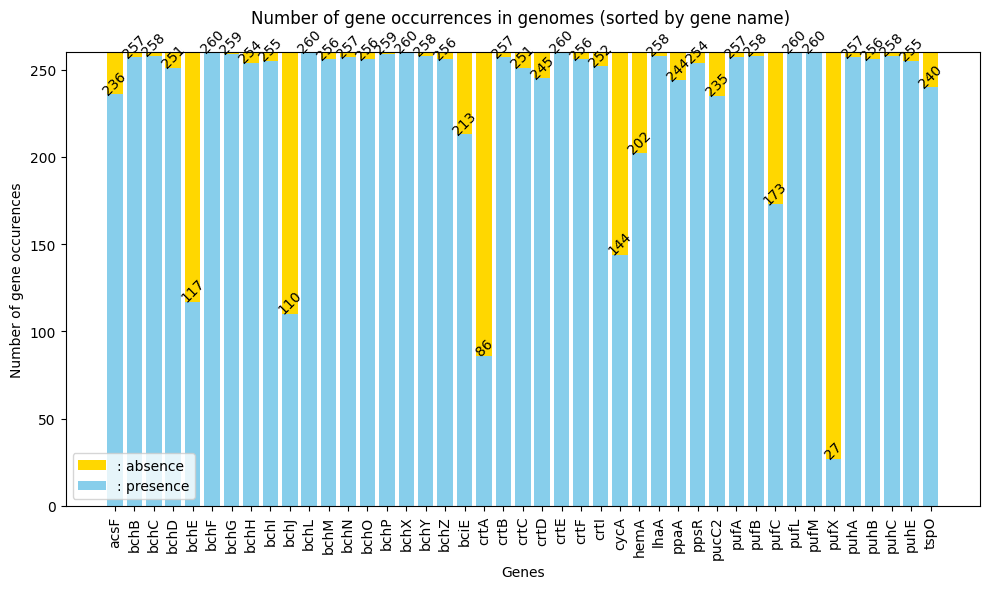

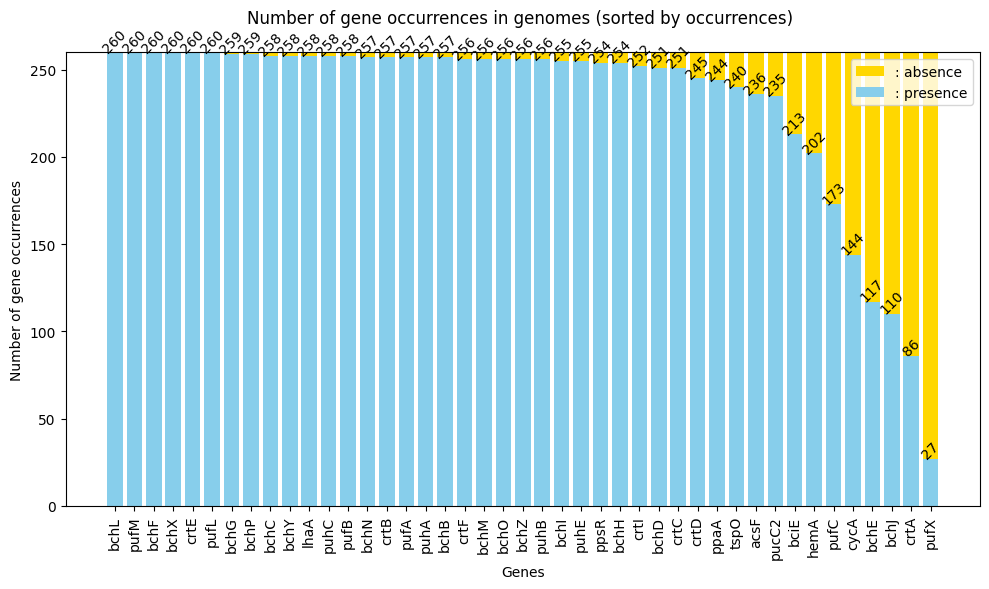

In [29]:
PGC_genes=["acsF","bchC","bchE","bchG","bchI","bchL","bchN","bchP","bchY","bciE","crtB","crtD","crtF","cycA","lhaA","ppsR","pufA","pufC","pufM","puhA","puhC","tspO","bchB","bchD","bchF","bchH","bchJ","bchM","bchO","bchX","bchZ","crtA","crtC","crtE","crtI","hemA","ppaA","pucC2","pufB","pufL","pufX","puhB","puhE"]
PGC_genes_synteny_matrix=["crtE", "pufM", "pufL", "pufA", "pufB", "bchZ", "bchY", "bchX", "bchC", "crtF", "crtD", "crtC", "crtB", "crtI", "bchO", "bchD", "bchI", "tspO", "bchP", "pucC2", "bchG", "ppsR", "bchF", "bchN", "bchB", "bchH", "bchL", "bchM", "lhaA", "puhA", "puhB", "puhC", "acsF", "puhE", "hemA", "bchE"]
PGC_genes_jannaschia=["tspO", "crtB", "crtI", "crtA", "bchI", "bchD", "bchO", "cycA", "hemA", "puhE", "acsF", "bciE", "puhC", "puhB", "puhA", "lhaA", "bchM", "bchL", "bchH", "bchB", "bchN", "bchF", "ppaA", "ppsR", "bchG", "pucC2", "bchP", "pufC", "pufX", "pufM", "pufL", "pufA", "pufB", "bchZ", "bchY", "bchX", "bchC", "crtF", "crtE", "crtD", "crtC", "bchJ"]
PGCfinder_output_gatherer(df_list_PGC, PGC_genes)
PGCfinder_output_gatherer_sorted(df_list_PGC, PGC_genes)

In [21]:
def plot_gene_scores(gene_scores, lists_genes):
    plt.figure(figsize=(12, 8))
    data_to_plot = [gene_scores[gene] for gene in lists_genes]
    plt.boxplot(data_to_plot, vert=True, patch_artist=True, tick_labels=lists_genes)

    plt.xlabel('Genes')
    plt.ylabel('Scores')
    plt.title('Boxplot of Gene Scores')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def plot_gene_scores_without_outliers(gene_scores, lists_genes):
    plt.figure(figsize=(12, 8))
    data_to_plot = [gene_scores[gene] for gene in lists_genes]
    plt.boxplot(data_to_plot, vert=True, patch_artist=True, tick_labels=lists_genes, showfliers=False)

    plt.xlabel('Genes')
    plt.ylabel('Scores')
    plt.title('Boxplot of Gene Scores (Without Outliers)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


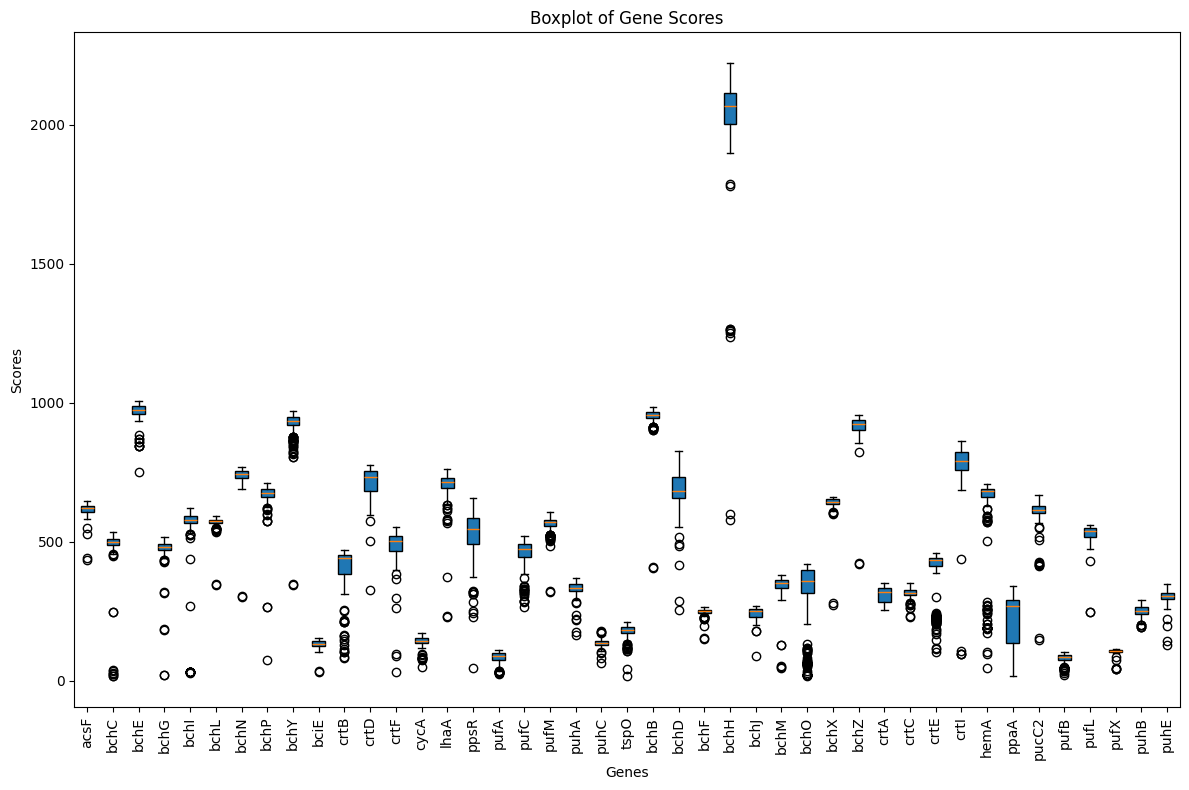

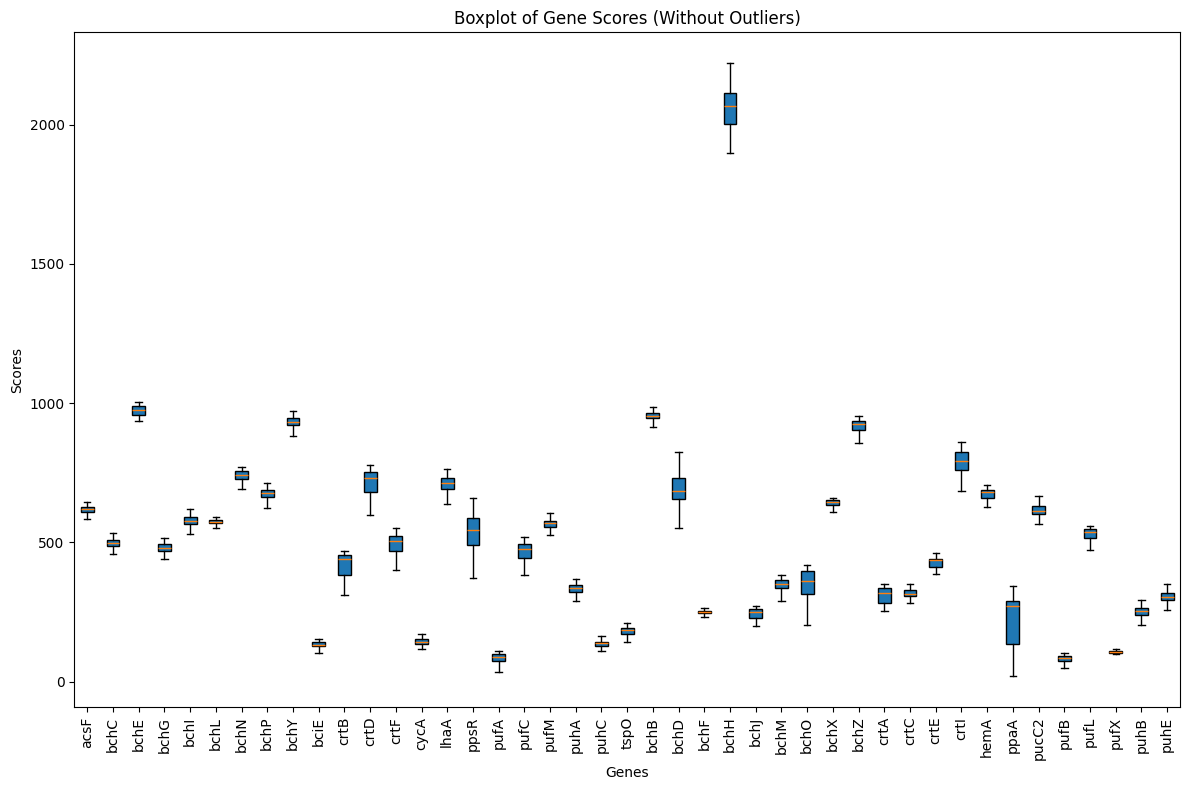

In [22]:
# Créer le dictionnaire gene_scores
gene_scores = create_gene_scores(df_list_PGC, PGC_genes, data_path)

# Utiliser gene_scores pour créer des graphiques
plot_gene_scores(gene_scores, PGC_genes)
plot_gene_scores_without_outliers(gene_scores, PGC_genes)

In [23]:
def plot_gene_score_distribution(gene_name, df_list, data_path):
    dfs = {}
    df_results = df_list.copy()
    df_results["to_compare"] = df_results["Assembly"].str.replace('GCA_', '')

    for index, row in df_results.iterrows():
        genome_gcf = f"GCF_{row['to_compare']}"
        genome_gca = f"GCA_{row['to_compare']}"
        path_gcf = os.path.join(data_path, genome_gcf, "PGCfinder", "best_solution.tsv")
        path_gca = os.path.join(data_path, genome_gca, "PGCfinder", "best_solution.tsv")

        if os.path.exists(path_gcf):
            genome = genome_gcf
            path_to_gff = path_gcf
        elif os.path.exists(path_gca):
            genome = genome_gca
            path_to_gff = path_gca
        else:
            print(f"No PGCfinder output found for {row['Assembly']}")
            continue

        dfs[genome] = pd.read_csv(path_to_gff, sep="\t", comment="#")

    # Liste pour stocker les scores du gène spécifié
    gene_scores = []

    # Boucle à travers chaque génome
    for genome in dfs:
        df = dfs[genome]
        if gene_name in df['gene_name'].values:
            scores = df[df['gene_name'] == gene_name]['hit_score'].tolist()
            gene_scores.extend(scores)

    if not gene_scores:
        print(f"No scores found for gene: {gene_name}")
        return

    # Créer un histogramme de la distribution des scores
    plt.figure(figsize=(10, 6))
    sns.histplot(gene_scores, bins=20, kde=True, color='skyblue')

    plt.xlabel('Hit Score')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Hit Scores for Gene: {gene_name}')
    plt.tight_layout()
    plt.show()

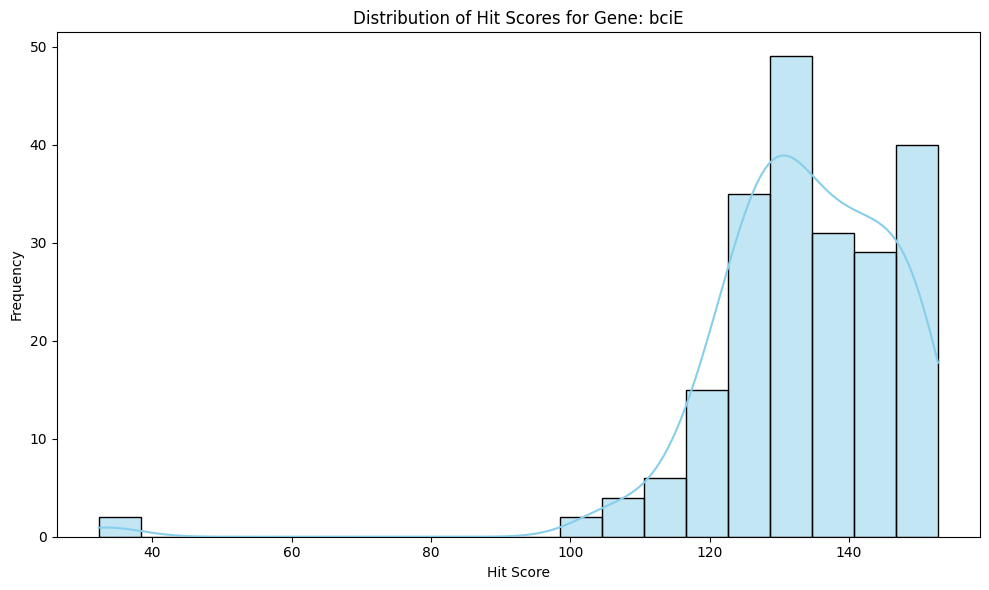

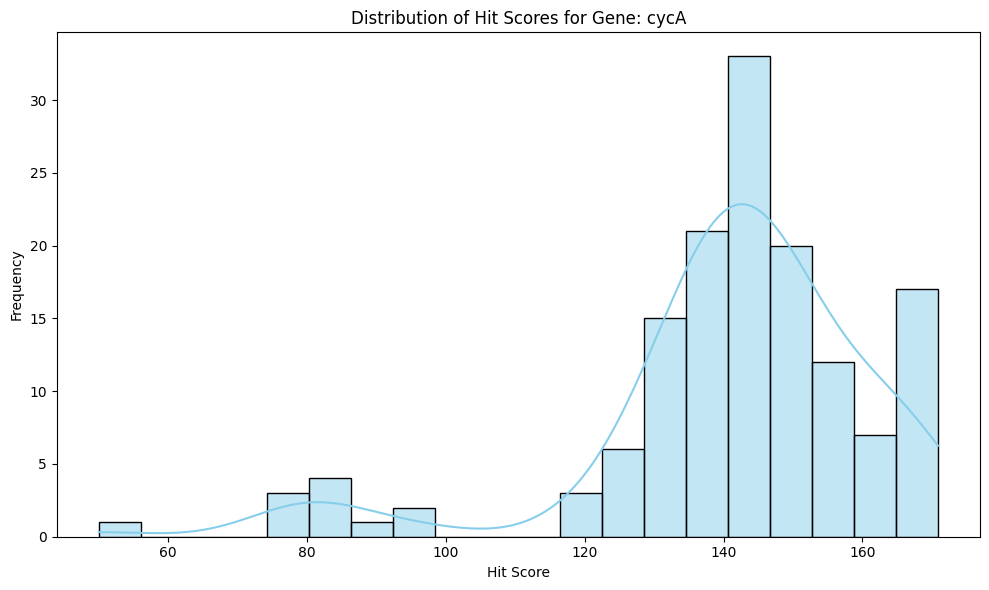

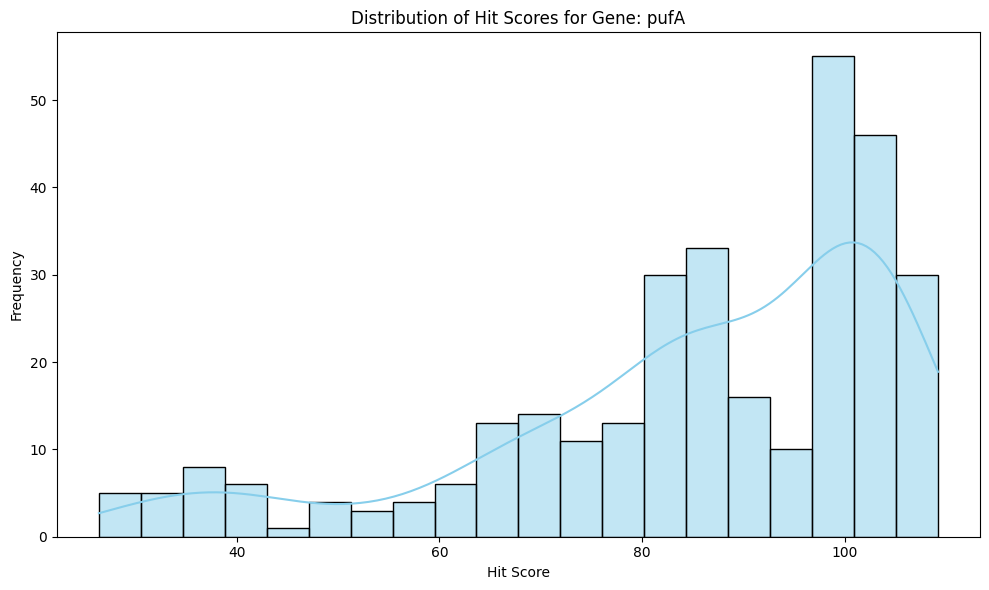

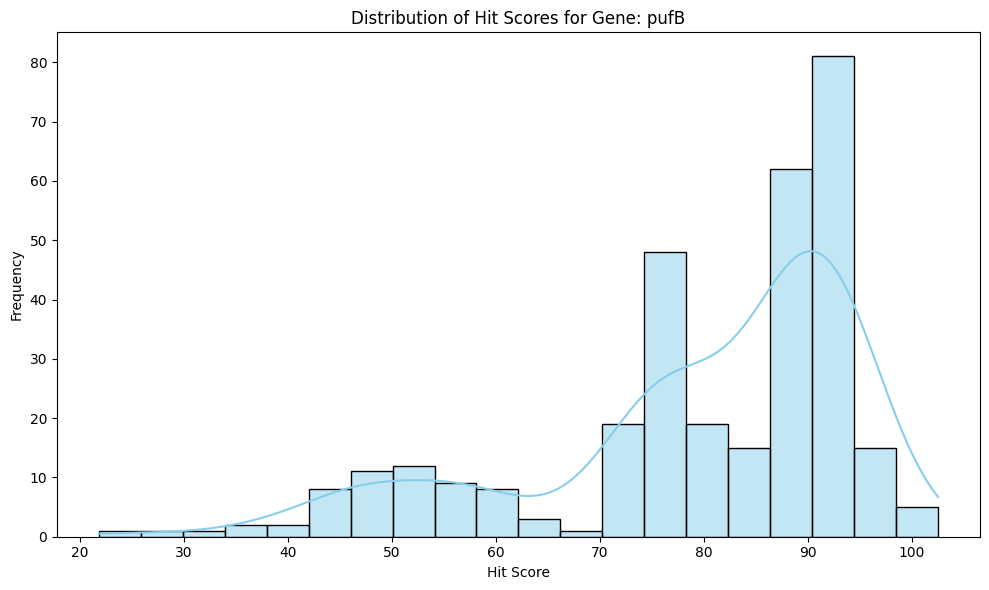

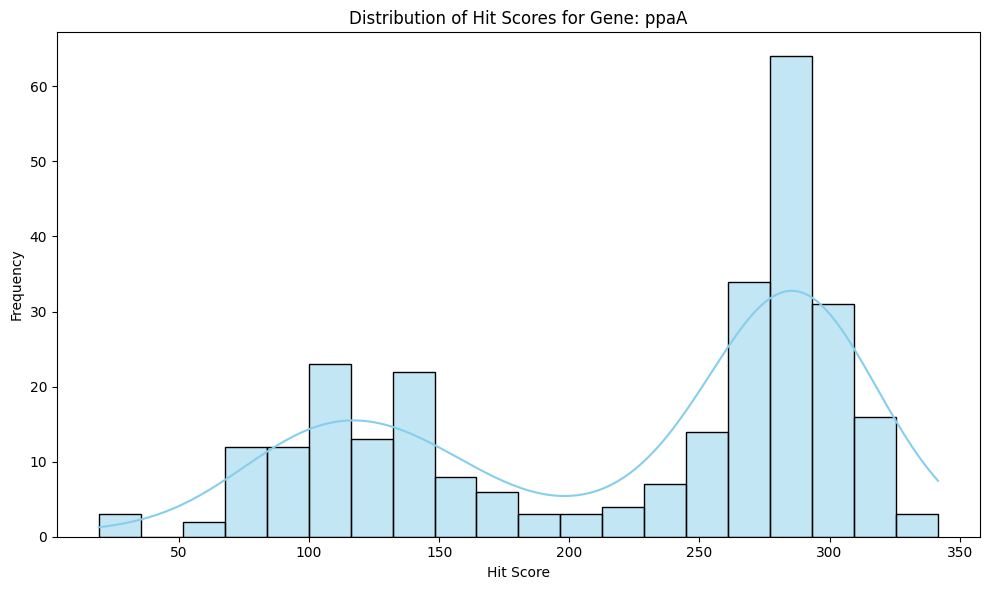

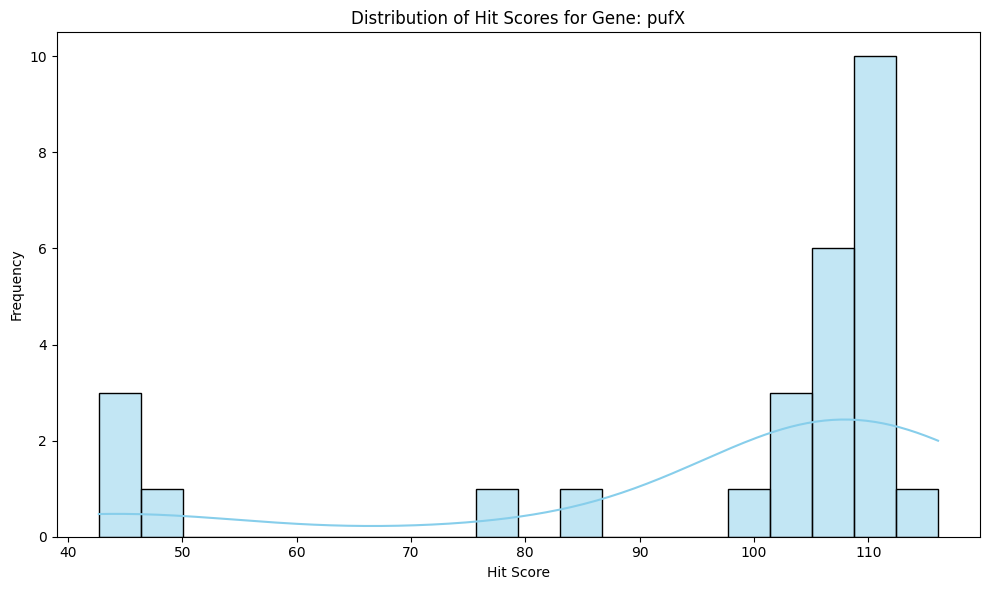

In [24]:
plot_gene_score_distribution("bciE", df_list_PGC, data_path)
plot_gene_score_distribution("cycA", df_list_PGC, data_path)
plot_gene_score_distribution("pufA", df_list_PGC, data_path)
plot_gene_score_distribution("pufB", df_list_PGC, data_path)
plot_gene_score_distribution("ppaA", df_list_PGC, data_path)
plot_gene_score_distribution("pufX", df_list_PGC, data_path)

In [25]:
def plot_violin(gene_scores, lists_genes):
    plt.figure(figsize=(12, 8))
    data_to_plot = [gene_scores[gene] for gene in lists_genes]
    sns.violinplot(data=data_to_plot)
    plt.xticks(ticks=range(len(lists_genes)), labels=lists_genes, rotation=90)
    plt.xlabel('Genes')
    plt.ylabel('Scores')
    plt.title('Violin Plot of Gene Scores')
    plt.tight_layout()
    plt.show()

def plot_heatmap(gene_scores, lists_genes):
    # Create a DataFrame for the heatmap
    heatmap_data = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in gene_scores.items()]))
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".2f")
    plt.xlabel('Genomes')
    plt.ylabel('Genes')
    plt.title('Heatmap of Gene Scores')
    plt.tight_layout()
    plt.show()

def plot_scatter(gene_scores, gene1, gene2, df_list, data_path):
    # Create a DataFrame to store the aligned scores
    aligned_scores = pd.DataFrame(index=df_list['Assembly'])

    # Align scores for gene1
    aligned_scores[gene1] = pd.Series(gene_scores[gene1], index=df_list['Assembly'])

    # Align scores for gene2
    aligned_scores[gene2] = pd.Series(gene_scores[gene2], index=df_list['Assembly'])

    # Drop rows with missing values (optional, depending on your needs)
    aligned_scores = aligned_scores.dropna()

    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(aligned_scores[gene1], aligned_scores[gene2], alpha=0.5)
    plt.xlabel(f'Scores for {gene1}')
    plt.ylabel(f'Scores for {gene2}')
    plt.title(f'Scatter Plot of Scores for {gene1} vs {gene2}')
    plt.tight_layout()
    plt.show()

def plot_bar(gene_scores, lists_genes):
    means = [np.mean(gene_scores[gene]) for gene in lists_genes]
    stds = [np.std(gene_scores[gene]) for gene in lists_genes]
    plt.figure(figsize=(12, 8))
    plt.bar(lists_genes, means, yerr=stds, capsize=5, color='skyblue')
    plt.xlabel('Genes')
    plt.ylabel('Average Score')
    plt.title('Bar Plot of Average Gene Scores')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def plot_pairplot(gene_scores, lists_genes):
    df = pd.DataFrame(gene_scores)
    sns.pairplot(df)
    plt.suptitle('Pair Plot of Gene Scores', y=1.02)
    plt.show()


def plot_cdf(gene_scores, lists_genes):
    plt.figure(figsize=(12, 8))
    for gene in lists_genes:
        sorted_scores = np.sort(gene_scores[gene])
        cdf = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
        plt.plot(sorted_scores, cdf, label=gene)
    plt.xlabel('Scores')
    plt.ylabel('CDF')
    plt.title('CDF Plot of Gene Scores')
    plt.legend()
    plt.tight_layout()
    plt.show()


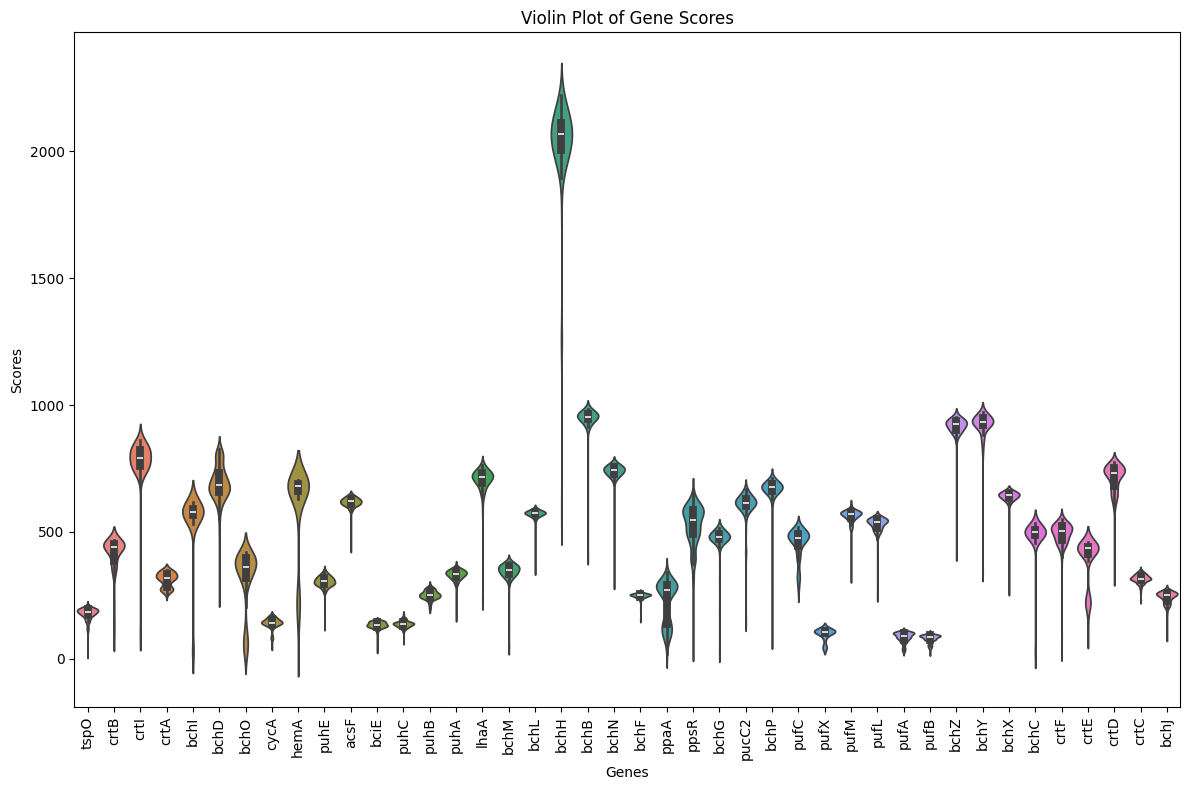

In [30]:
plot_violin(gene_scores, PGC_genes_jannaschia)
#plot_heatmap(gene_scores, PGC_genes) # Useless
#plot_scatter(gene_scores, 'bciE', 'acsF', df_list_PGC, data_path)
# plot_bar(gene_scores, PGC_genes)
# plot_pairplot(gene_scores, PGC_genes)
# plot_cdf(gene_scores, PGC_genes)